<a href="https://colab.research.google.com/github/eprayoga/Klasterisasi-Kategori-Berita-With-Kohonen-SOM/blob/main/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import collections
from math import log
import re
from collections import Counter
from sklearn.preprocessing import minmax_scale
from pylab import plot,axis,show,pcolor,colorbar,bone
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
!pip install minisom
import minisom
from minisom import MiniSom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=04c715dfae2b1cab0858ff27646f474f55deb0d3594a3f49b2dc1d1f7a28833e
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


# Load data


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/eprayoga/Klasterisasi-Kategori-Berita-With-Kohonen-SOM/main/Datasets/bbc-text.csv')
stop_words = pd.read_csv('https://raw.githubusercontent.com/eprayoga/Klasterisasi-Kategori-Berita-With-Kohonen-SOM/main/Datasets/stopwords.txt', sep ='\t')
#data_df = pd.DataFrame(data)

In [3]:
x = df.loc[:]['text']
y = df.loc[:]['category']
class_labels = y.unique()
x = [re.sub("[^a-zA-Z ]+", "",txt) for txt in x]
x = [re.sub(r'\b\w{1,2}\b','',txt) for txt in x] 

target = np.zeros(len(y), dtype=int)
y_array = y.to_numpy(y)
target[y_array == 'business'] = 0
target[y_array == 'entertainment'] = 1
target[y_array == 'politics'] = 2
target[y_array == 'sport'] = 3
target[y_array == 'tech'] = 4


In [4]:
stopw_list = list(stop_words.columns)[0].split()
docs_list = list()
docs_list_split = list()
for txt in x:
    txt = txt.split()
    txt_n = ""
    for word in txt:
        if(word in stopw_list) == False:
            txt_n =txt_n+word+" "
    docs_list_split.append(txt_n.split())
    docs_list.append(txt_n)

In [5]:
def tfidf(doc, _corpus):
    dic = collections.defaultdict(int)
    for x in _corpus:
        for y in x:
            dic[y] += 1.
    return {x: doc[x] * log(len(_corpus) / dic[x]) for x in doc}
doc_sets = [Counter(doc.split()) for doc in docs_list]
docs_list_tfidf = [tfidf(x, doc_sets) for x in doc_sets]

In [6]:
df_tfidf_docs = pd.DataFrame(docs_list_tfidf)
df_tfidf_docs =  df_tfidf_docs.fillna(0)
data = df_tfidf_docs.to_numpy()
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
for i in range(data.shape[0]):
    temp = data[i]
    data[i] = minmax_scale(temp,feature_range=(0,1))

## Part A: SOM-WTA size = 1*5 

In [7]:
sample_num, words_num = df_tfidf_docs.shape
som_shape = (1,5)
som = MiniSom(som_shape[0], som_shape[1], words_num, sigma=3.5, learning_rate=0.2,
              activation_distance='euclidean')
som.random_weights_init(data)
som.train_batch(data, 30000, verbose=True)

/usr/local/lib/python3.10/dist-packages/minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 3.675424184211977


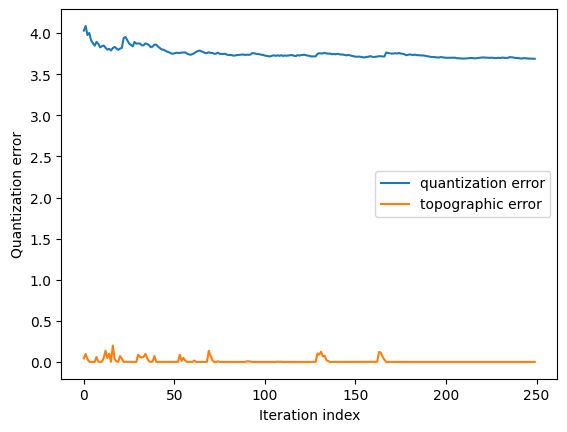

In [10]:
max_iter = 250
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('Quantization error')
plt.xlabel('Iteration index')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

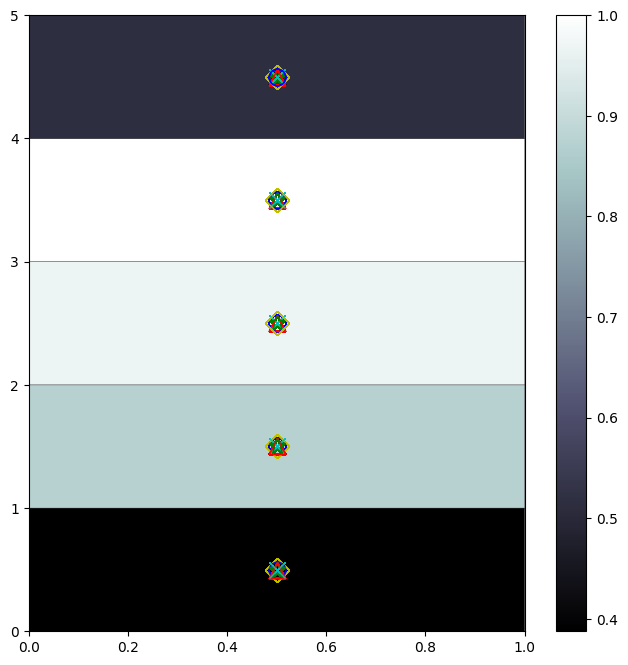

In [11]:
bone()
plt.figure(figsize=(8, 8))
pcolor(som.distance_map().T,edgecolors='k') # distance map as background
colorbar()
markers = [ "^" , "*" , "o" , "x" , "D" ]
colors = "rgbcy"
for cnt,xx in enumerate(data):
  w = som.winner(xx)
  plot(w[0]+.5,w[1]+.5,markers[target[cnt]],markerfacecolor='None',
       markeredgecolor=colors[target[cnt]],markersize=12)
label_names = {0:'business',1:'entertainment', 2:'politics', 3:'sport', 4:'tech'}
show()

[[693. 683. 311. 162. 376.]]


<Figure size 800x800 with 0 Axes>

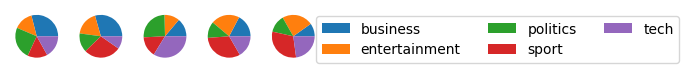

(0, 0) Counter({'business': 201, 'politics': 170, 'tech': 117, 'sport': 104, 'entertainment': 101})
(0, 4) Counter({'sport': 115, 'entertainment': 88, 'tech': 86, 'politics': 50, 'business': 37})
(0, 1) Counter({'business': 201, 'sport': 192, 'entertainment': 126, 'politics': 98, 'tech': 66})
(0, 2) Counter({'tech': 105, 'politics': 79, 'sport': 48, 'business': 43, 'entertainment': 36})
(0, 3) Counter({'sport': 52, 'entertainment': 35, 'business': 28, 'tech': 27, 'politics': 20})


,accuracy,precision,recall,f1-score
business,0.688539,0.224832,0.394118,0.286325
entertainment,0.693034,0.227376,0.394118,0.288379
politics,0.860225,0.252404,0.261845,0.257038
sport,0.927191,0.242991,0.101761,0.143448
tech,0.831011,0.234216,0.225049,0.229541


In [12]:
plt.figure(figsize=(8, 8))
frequencies = som.activation_response(data)
print(frequencies)
import matplotlib.gridspec as gridspec
label_names = {0:'business',1:'entertainment', 2:'politics', 3:'sport', 4:'tech'}
labels_map = som.labels_map(data, [label_names[t] for t in target])
fig = plt.figure(figsize=(4, 4))

the_grid = gridspec.GridSpec(som_shape[0], som_shape[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[position], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(2,1), ncol=3)
show()
for obj in labels_map.keys():
    print(obj ,labels_map[obj])
nerouns_dict = dict()
for neuron in labels_map.keys():
    tmp = max(labels_map[neuron].values())
    label = [name for name, counter in labels_map[neuron].items() if counter == tmp]
    nerouns_dict[neuron] = [label[0] , tmp, sum(labels_map[neuron].values())]
confusion_matrix = np.zeros((5,4))
names_to_class = {'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
for neuron , detail in nerouns_dict.items():
    confusion_matrix[neuron[1]][0] = (len(target) - detail[2])/len(target)
    confusion_matrix[neuron[1]][1] = detail[1]/(detail[1] + detail[2])
    confusion_matrix[neuron[1]][2] = detail[1]/len(target[target == names_to_class[detail[0]]])
    confusion_matrix[neuron[1]][3] = 2 * confusion_matrix[neuron[1]][2]*confusion_matrix[neuron[1]][1]/(
                                        confusion_matrix[neuron[1]][2]+confusion_matrix[neuron[1]][1])
     
confusion_df = pd.DataFrame(confusion_matrix,index = names_to_class.keys(), 
                            columns=['accuracy','precision','recall','f1-score'])
confusion_df

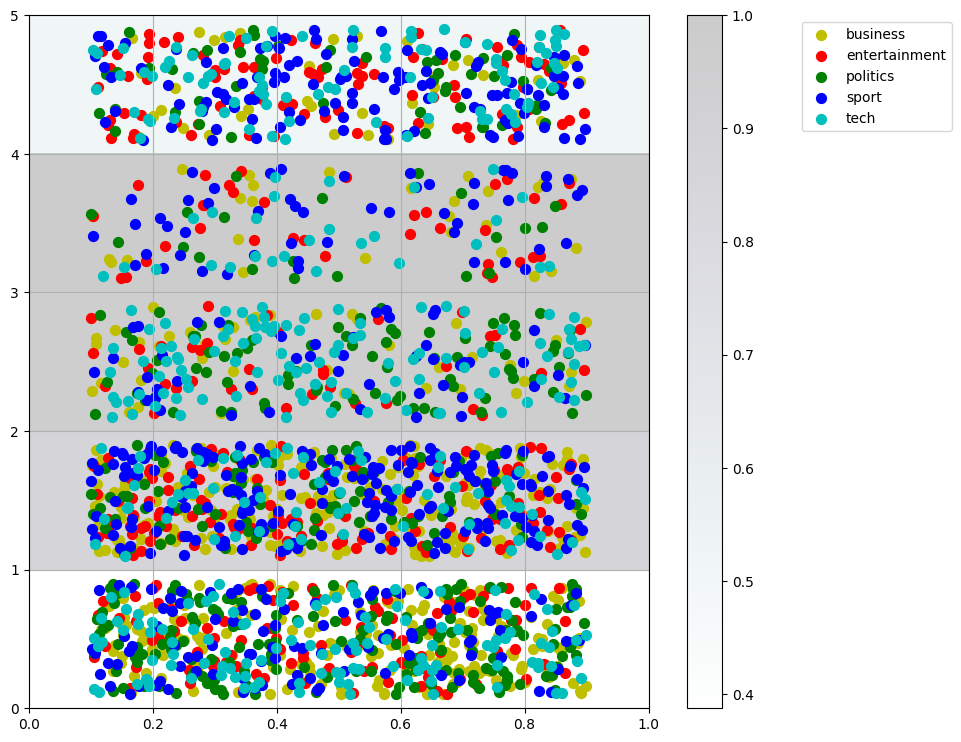

error for som with size (1, 5)


8204.496501362235

In [13]:
winner_coordinates = np.array([som.winner(x) for x in data]).T
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(bbox_to_anchor=(1.5,1))
plt.grid()
plt.show()
distance_data =  som._distance_from_weights(data)
dis_data_from_winner = dict()
for count in range (len(data)):
    i, j = winner_coordinates[0][count] , winner_coordinates[1][count]
    dis_tmp = distance_data[count].reshape(som_shape)[i][j]
    dis_data_from_winner[count] = dis_tmp
print('error for som with size', som_shape)
sum(list(dis_data_from_winner.values()))

In [14]:
nerouns_dict = dict()
for neuron in labels_map.keys():
    tmp = max(labels_map[neuron].values())
    label = [name for name, counter in labels_map[neuron].items() if counter == tmp]
    nerouns_dict[neuron] = [label[0] , tmp, sum(labels_map[neuron].values())]
confusion_matrix = np.zeros((5,4))
names_to_class = {'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
for neuron , detail in nerouns_dict.items():
    confusion_matrix[neuron[1]][0] = (len(target) - detail[2])/len(target)
    confusion_matrix[neuron[1]][1] = detail[1]/(detail[1] + detail[2])
    confusion_matrix[neuron[1]][2] = detail[1]/len(target[target == names_to_class[detail[0]]])
    confusion_matrix[neuron[1]][3] = 2 * confusion_matrix[neuron[1]][2]*confusion_matrix[neuron[1]][1]/(
                                        confusion_matrix[neuron[1]][2]+confusion_matrix[neuron[1]][1])
     
confusion_df = pd.DataFrame(confusion_matrix,index = names_to_class.keys(), 
                            columns=['accuracy','precision','recall','f1-score'])
confusion_df

,accuracy,precision,recall,f1-score
business,0.688539,0.224832,0.394118,0.286325
entertainment,0.693034,0.227376,0.394118,0.288379
politics,0.860225,0.252404,0.261845,0.257038
sport,0.927191,0.242991,0.101761,0.143448
tech,0.831011,0.234216,0.225049,0.229541


## Part B: SOM size = (3,3) ,(4,4) ,(5,5)

In [15]:
sample_num, words_num = df_tfidf_docs.shape
som_shape = (5,5)
som = MiniSom(som_shape[0], som_shape[1], words_num, sigma=3 , learning_rate=0.25,
              neighborhood_function='gaussian',topology='hexagonal', 
              activation_distance='euclidean')
som.random_weights_init(data)
som.train_batch(data, 10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.6525315510935785


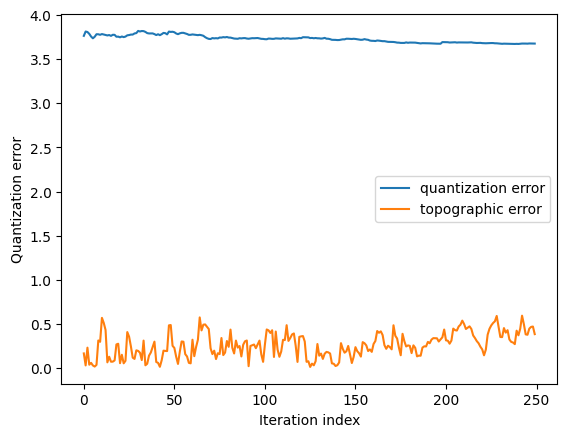

In [16]:
max_iter = 250
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('Quantization error')
plt.xlabel('Iteration index')
plt.legend()
plt.show()

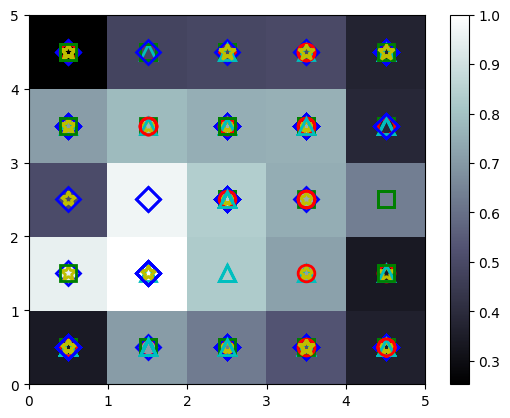

In [17]:
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()
markers = ['o','s','D','^' , '*' ]
colors = ['r','g','b','c','y']
for cnt,xx in enumerate(data):
  w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
  plot(w[0]+.5,w[1]+.5,markers[target[cnt]],markerfacecolor='None',
       markeredgecolor=colors[target[cnt]],markersize=12,markeredgewidth=2)
show()

       0    1      2      3     4
0  176.0  3.0    3.0   20.0  14.0
1   20.0  8.0    2.0    7.0   6.0
2  314.0  3.0  118.0  140.0  12.0
3  293.0  6.0    6.0  613.0  11.0
4  371.0  8.0    4.0   17.0  50.0


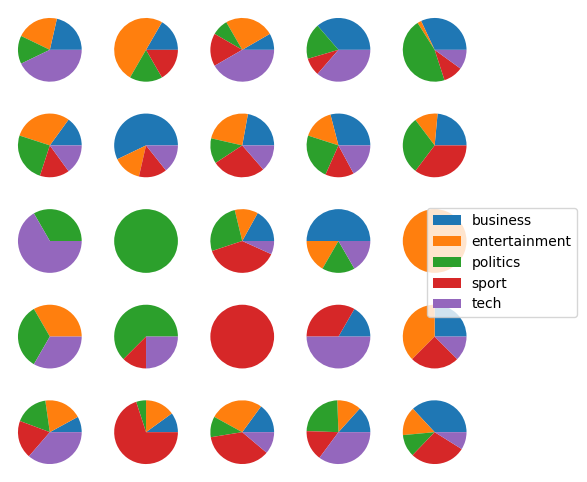

(0, 0) Counter({'tech': 64, 'entertainment': 34, 'sport': 34, 'politics': 30, 'business': 14})
(0, 1) Counter({'politics': 1, 'tech': 1, 'entertainment': 1})
(0, 2) Counter({'tech': 2, 'politics': 1})
(0, 3) Counter({'entertainment': 6, 'politics': 5, 'business': 3, 'sport': 3, 'tech': 3})
(0, 4) Counter({'tech': 6, 'business': 3, 'entertainment': 3, 'politics': 2})
(1, 0) Counter({'sport': 14, 'entertainment': 3, 'business': 2, 'politics': 1})
(1, 1) Counter({'politics': 5, 'tech': 2, 'sport': 1})
(1, 2) Counter({'politics': 2})
(1, 3) Counter({'business': 4, 'tech': 1, 'entertainment': 1, 'sport': 1})
(1, 4) Counter({'entertainment': 3, 'business': 1, 'sport': 1, 'politics': 1})
(2, 0) Counter({'sport': 114, 'entertainment': 85, 'business': 47, 'tech': 35, 'politics': 33})
(2, 1) Counter({'sport': 3})
(2, 2) Counter({'sport': 45, 'politics': 31, 'business': 20, 'entertainment': 14, 'tech': 8})
(2, 3) Counter({'sport': 38, 'entertainment': 34, 'business': 31, 'tech': 19, 'politics': 1

In [18]:
winner_coordinates = np.array([som.winner(x) for x in data]).T
frequencies = som.activation_response(data)
print(pd.DataFrame(frequencies))
import matplotlib.gridspec as gridspec
label_names = {0:'business',1:'entertainment', 2:'politics', 3:'sport', 4:'tech'}
labels_map = som.labels_map(data, [label_names[t] for t in target])
fig = plt.figure(figsize=(6, 6))
the_grid = gridspec.GridSpec(som_shape[0], som_shape[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[som_shape[0]-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(6,1))
show()
labelmap_df = labels_map.items()
labelmap_df = sorted(labelmap_df)
for neroun , detail in labelmap_df:
    print(neroun ,detail)


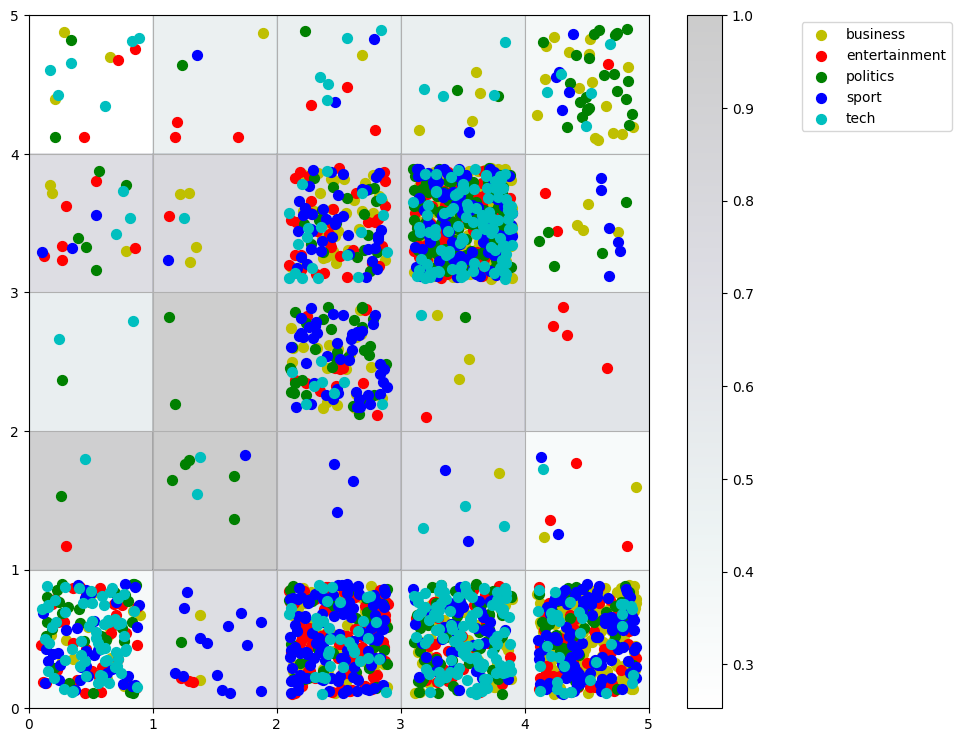

error for som with size (5, 5)


8177.974470700557

In [19]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(bbox_to_anchor=(1.5,1))
plt.grid()
plt.show()
distance_data =  som._distance_from_weights(data)
dis_data_from_winner = dict()
for count in range (len(data)):
    i, j = winner_coordinates[0][count] , winner_coordinates[1][count]
    dis_tmp = distance_data[count].reshape(som_shape)[i][j]
    dis_data_from_winner[count] = dis_tmp
print('error for som with size', som_shape)
sum(list(dis_data_from_winner.values()))

In [20]:
nerouns_dict = dict()
for neuron in labels_map.keys():
    tmp = max(labels_map[neuron].values())
    label = [name for name, counter in labels_map[neuron].items() if counter == tmp]
    nerouns_dict[neuron] = [label[0] , tmp, sum(labels_map[neuron].values())]
confusion_matrix = np.zeros((5,4))
names_to_class = {'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
for neuron , detail in nerouns_dict.items():
    confusion_matrix[neuron[1]][0] = (len(target) - detail[2])/len(target)
    confusion_matrix[neuron[1]][1] = detail[1]/(detail[1] + detail[2])
    confusion_matrix[neuron[1]][2] = detail[1]/len(target[target == names_to_class[detail[0]]])
    confusion_matrix[neuron[1]][3] = 2 * confusion_matrix[neuron[1]][2]*confusion_matrix[neuron[1]][1]/(
                                        confusion_matrix[neuron[1]][2]+confusion_matrix[neuron[1]][1])
     
confusion_df = pd.DataFrame(confusion_matrix,index = names_to_class.keys(), 
                            columns=['accuracy','precision','recall','f1-score'])
confusion_df

,accuracy,precision,recall,f1-score
business,0.991011,0.411765,0.027397,0.051376
entertainment,0.997303,0.333333,0.007481,0.014634
politics,0.999101,0.500000,0.004796,0.009501
sport,0.992360,0.260870,0.011742,0.022472
tech,0.997303,0.333333,0.007772,0.015190
